In [1]:
from DatasetHandler.BiwiBrowser import *
from LSTM_VGG16.LSTM_VGG16Helper import *
%matplotlib inline

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
output_begin = 4
num_outputs = 1

In [14]:
timesteps = 16 # TimeseriesGenerator Handles overlapping
learning_rate = 0.0001
in_epochs = 1
out_epochs = 7
train_batch_size = 10
test_batch_size = 10

In [15]:
subjectList = [1, 2, 3, 4, 5, 7, 8, 11, 12, 14] #9[i for i in range(1, 9)] + [i for i in range(10, 25)] except [6, 13, 10, ]
testSubjects = [9]

In [16]:
num_datasets = len(subjectList)

In [17]:
def getFinalModel(num_outputs = num_outputs):
    inp = (224, 224, 3) # BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', input_shape = inp, include_top=False) #BIWI_Frame_Shape
    """"
    vgg_model.layers.pop()
    vgg_model.outputs = [vgg_model.layers[-1].output]#
    vgg_model.output_layers = [vgg_model.layers[-1]]#
    vgg_model.layers[-1].outbound_nodes = []#
    """
    nb_pretrained_layers = len(vgg_model.layers)
     #for layer in vgg_model.layers:
     #   layer.trainable = False
    #print(nb_pretrained_layers)
    #vgg_model.summary()
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2]), name = 'tdVGG16')) 
    rnn.add(TimeDistributed(Flatten()))
    
    """
    rnn.add(TimeDistributed(Dropout(0.25)))#
    rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc1024'))#, activation='relu'
    rnn.add(TimeDistributed(Dropout(0.25)))#
    rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc104'))   # 
    rnn.add(TimeDistributed(Dropout(0.25)))#
    rnn.add(TimeDistributed(Dense(1024, activation='relu'), name = 'fc10'))#
    rnn.add(TimeDistributed(Dropout(0.25)))
    """

    rnn.add(LSTM(256, dropout=0.25, recurrent_dropout=0.25)) #
   # rnn.add(Flatten())
    rnn.add(Dense(num_outputs))
    #print(len(rnn.layers))
    for layer in rnn.layers[:1]:#
        layer.trainable = False#
    adam = optimizers.Adam(lr=learning_rate)
    rnn.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])
    return rnn

In [18]:
keras.backend.clear_session()#
full_model = getFinalModel(num_outputs = num_outputs)

In [19]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tdVGG16 (TimeDistributed)    (None, 16, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 25088)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               25953280  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 40,668,225
Trainable params: 25,953,537
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
full_model = trainImageModelForEpochs(full_model, out_epochs, subjectList, testSubjects, timesteps, False, output_begin, num_outputs, batch_size = train_batch_size, in_epochs = in_epochs)

All frames and annotations from 10 datasets have been read by 2019-01-12 23:28:08.528501
1. set (Dataset 14) being trained for epoch 1!
Epoch 1/1
79/79 [==============================] - 54s 682ms/step - loss: 0.0091 - mean_absolute_error: 0.0756
2. set (Dataset 8) being trained for epoch 1!
Epoch 1/1
76/76 [==============================] - 54s 706ms/step - loss: 0.0102 - mean_absolute_error: 0.0803
3. set (Dataset 7) being trained for epoch 1!
Epoch 1/1
73/73 [==============================] - 52s 713ms/step - loss: 0.0095 - mean_absolute_error: 0.0773
4. set (Dataset 12) being trained for epoch 1!
Epoch 1/1
72/72 [==============================] - 51s 713ms/step - loss: 0.0082 - mean_absolute_error: 0.0742
5. set (Dataset 11) being trained for epoch 1!
Epoch 1/1
56/56 [==============================] - 40s 713ms/step - loss: 0.0061 - mean_absolute_error: 0.0625
6. set (Dataset 3) being trained for epoch 1!
Epoch 1/1
72/72 [==============================] - 51s 712ms/step - loss: 0.0

49/49 [==============================] - 35s 709ms/step - loss: 0.0116 - mean_absolute_error: 0.0889
10. set (Dataset 7) being trained for epoch 5!
Epoch 1/1
73/73 [==============================] - 52s 718ms/step - loss: 0.0144 - mean_absolute_error: 0.1011
Epoch 5 completed!
All frames and annotations from 10 datasets have been read by 2019-01-13 00:15:33.983343
1. set (Dataset 1) being trained for epoch 6!
Epoch 1/1
49/49 [==============================] - 34s 703ms/step - loss: 0.0100 - mean_absolute_error: 0.0798
2. set (Dataset 2) being trained for epoch 6!
Epoch 1/1
50/50 [==============================] - 36s 711ms/step - loss: 0.0089 - mean_absolute_error: 0.0754
3. set (Dataset 3) being trained for epoch 6!
Epoch 1/1
72/72 [==============================] - 51s 713ms/step - loss: 0.0136 - mean_absolute_error: 0.0929
4. set (Dataset 4) being trained for epoch 6!
Epoch 1/1
73/73 [==============================] - 52s 718ms/step - loss: 0.0056 - mean_absolute_error: 0.0553
5. se

In [30]:
test_generators, test_labelSets = getTestBiwiForImageModel(testSubjects, timesteps, False, output_begin, num_outputs, batch_size = test_batch_size)
test_gen, test_labels = test_generators[0], test_labelSets[0] #[1]

All frames and annotations from 1 datasets have been read by 2019-01-13 00:34:30.187167


In [31]:
predictions = full_model.predict_generator(test_gen, verbose = 1)
#predictions = full_model.predict(test_gen[0][0], verbose = 1)
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)

87/87 [==============================] - 57s 659ms/step


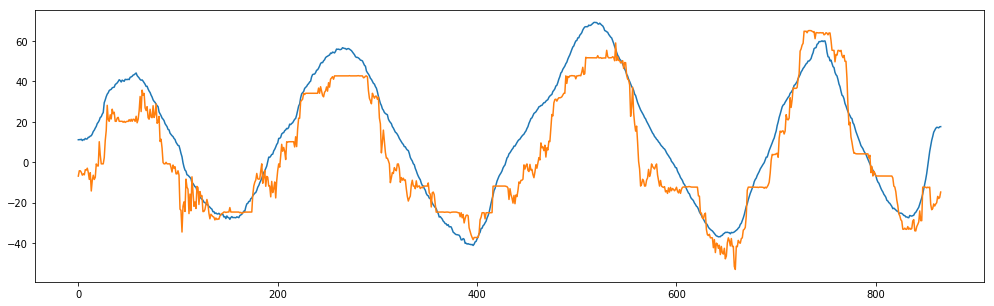

In [32]:
plt.figure(figsize=(17,5))
plt.plot(output1*90)

In [33]:
dif = (test_labels[timesteps:, :1] - predictions[:, :1])*90
print("The average error on Yaw angle estimation: %.2f Degree" % (np.abs(dif).mean()))

The average error on Yaw angle estimation: 11.11 Degree


In [21]:
dif = (test_labels[timesteps:, :1] - predictions[:, :1])*90
print("The average error on Yaw angle estimation: %.2f Degree" % (np.abs(dif).mean()))

The average error on Yaw angle estimation: 6.41 Degree


In [13]:
dif = (test_labels[timesteps:, :1] - predictions[:, :1])*90
print("The average error on Yaw angle estimation: %.2f Degree" % (np.abs(dif).mean()))

The average error on Yaw angle estimation: 8.28 Degree


In [ ]:
full_model.evaluate_generator(test_gen)

In [ ]:
exit()